Reading the LinkedIn profiles and companies data.

In [0]:
from pyspark.sql.types import *
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd
from pyspark.sql.functions import size, col, avg, expr, explode, countDistinct, count, length, monotonically_increasing_id
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

spark = SparkSession.builder.getOrCreate()

In [0]:
profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

Reading our pre scraped LinkedIn data into a PD df.

In [0]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
jobs_df = pd.read_csv('/dbfs/FileStore/shared_uploads/omernevo@campus.technion.ac.il/Jobs_linkedin.csv')

# Display the DataFrame
jobs_df.head()

Unnamed: 0 
 company 
 job title 
 level 
 full description 
 seniority level 
 employment type 
 job function 
 industries 
 job id 
 
 
 
 
 0 
 0 
 Mindrift 
 Proofreader (Remote) - Freelance 
 Mid-Senior level 
 If you're a professional editor, we have an ex... 
 Mid-Senior level 
 Part-time 
 Marketing, Public Relations, and Writing/Editing 
 Technology, Information and Internet 
 3868760251 
 
 
 1 
 1 
 Seronda Network 
 Data Entry Specialist 
 Entry level 
 Join Seronda Networks as a Data Entry Speciali... 
 Entry level 
 Full-time 
 Administrative 
 Staffing and Recruiting 
 3868734834 
 
 
 2 
 2 
 Quaker Houghton 
 Director Global Procurement - Corporate Services 
 Director 
 Company Overview:At Quaker Houghton, we are ex... 
 Director 
 Full-time 
 Purchasing and Supply Chain 
 Chemical Manufacturing 
 3868742008 
 
 
 3 
 3 
 Seronda Network 
 Entry Level Marketing Assistant 
 Entry level 
 Seronda Networks is Hiring: Entry Level Market... 
 Entry level 
 Full-time 
 Marketing and Sales 
 Staffing and Recruiting 
 3868735290 
 
 
 4 
 4 
 Actalent 
 Architectural Designer 
 Entry level 
 Description:The Project Designer is responsibl... 
 Entry level 
 Full-time 
 Design, Art/Creative, and Information Technology 
 Business Consulting and Services 
 3868739623

Some insights regarding our scraped data:
-Unique values in each column 
-Top 15 most common industries

In [0]:
jobs_df.nunique()

Out[66]: Unnamed: 0          2208
company             1021
job title           1683
level                  7
full description    2208
seniority level        7
employment type        6
job function         143
industries           242
job id              2208
dtype: int64

In [0]:
# Calculate the count of each unique value in the "industries" column
value_counts = jobs_df['industries'].value_counts()

# Print the top 15 most common values and their counts
print(value_counts.head(15))

Internet Publishing                     381
Hospitals and Health Care               291
Staffing and Recruiting                 204
Business Consulting and Services        160
IT Services and IT Consulting           114
Security and Investigations             105
Software Development                     65
Government Administration                40
Construction                             38
Technology, Information and Internet     30
Higher Education                         25
Financial Services                       24
Hospitality                              20
Real Estate                              20
Human Resources Services                 18
Name: industries, dtype: int64


Create an embedding for each row (job).

In [0]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, Word2Vec
from pyspark.sql.functions import concat_ws, split
import pandas as pd


df = spark.createDataFrame(jobs_df)

# Tokenize the relevant columns
tokenizer_job = Tokenizer(inputCol="job title", outputCol="job_title_tokens")
df = tokenizer_job.transform(df)

tokenizer_industries = Tokenizer(inputCol="industries", outputCol="industries_tokens")
df = tokenizer_industries.transform(df)

tokenizer_seniority = Tokenizer(inputCol="seniority level", outputCol="seniority_tokens")
df = tokenizer_seniority.transform(df)

tokenizer_employment = Tokenizer(inputCol="employment type", outputCol="employment_tokens")
df = tokenizer_employment.transform(df)

# Combine the tokens into a single list of words
df = df.withColumn("all_tokens", concat_ws(" ", "job_title_tokens", "industries_tokens","seniority_tokens","employment_tokens"))

# Convert the 'all_tokens' column to an array of strings
df = df.withColumn("all_tokens", split("all_tokens", " "))

# Create a Word2Vec model
word2Vec = Word2Vec(vectorSize=100, minCount=5, inputCol='all_tokens', outputCol='embedding')

# Fit the Word2Vec model
model = word2Vec.fit(df)

# Transform the DataFrame to add the embeddings
result_df = model.transform(df)

# Convert the resulting DataFrame back to Pandas
result_df_pd = result_df.toPandas()


/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field embedding. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


####First try K-means
Clustering using K-Means algorithm.

At first we were trying to decide K using the elbow method, as presented below:


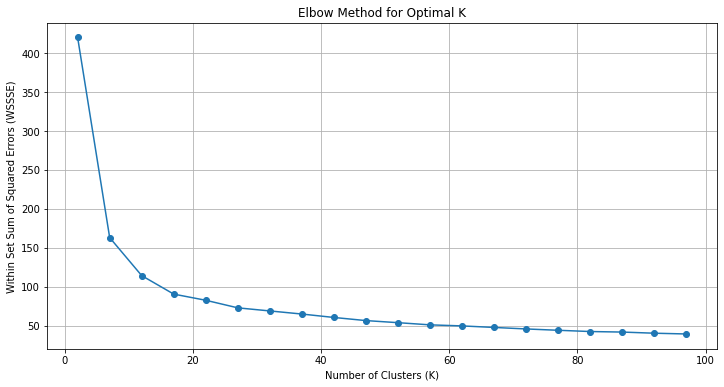

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np

# Convert the 'embedding' column to a format suitable for clustering
df_cluster = result_df.select('job id', 'embedding')

# Create a VectorAssembler to combine the 'embedding' column into a single features column
assembler = VectorAssembler(inputCols=['embedding'], outputCol='features')
df_cluster = assembler.transform(df_cluster)

# Select only the columns needed for clustering
df_cluster = df_cluster.select('job id', 'features')

# Range of K values to test
k_values = range(2,102,5)  # Test for K from 2 to 20

# Calculate the Within Set Sum of Squared Errors (WSSSE) for different values of k
wssse_list = []
for k in k_values:
    kmeans = KMeans(k=k, seed=1)
    model = kmeans.fit(df_cluster)
    wssse = model.summary.trainingCost
    wssse_list.append(wssse)

# Plot the elbow curve
plt.figure(figsize=(12, 6))
plt.plot(k_values, wssse_list, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
#plt.xticks(np.arange(min(k_values), max(k_values)+1, 1.0))
plt.grid(True)
plt.show()


We decided to prioritize creating smaller, more specific clusters rather than optimizing for a specific K value. This approach allows us to form clusters that can distinguish finer details, such as different seniority levels within the same industry.

In [0]:
# Create a KMeans model
kmeans = KMeans(k=160, seed=1)

# Fit the KMeans model
model = kmeans.fit(df_cluster)

# Make predictions
predictions = model.transform(df_cluster)

# Join the clustered result back to the original DataFrame
result_with_clusters = result_df.join(predictions.select('job id', 'prediction'), on='job id', how='inner')

####Second try DBSCAN clustering

In [0]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

embeddings = result_df_pd['embedding'].to_list()

# Convert embeddings to a numpy array
X = np.array(embeddings)

# Standardize the data
X = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=3)
clusters = dbscan.fit_predict(X)

# Add the cluster labels to the DataFrame
result_df_pd['cluster'] = clusters

# Group by 'cluster' and count the occurrences
cluster_count = result_df_pd.groupby('cluster').size()

# Print the number of clusters
print(f'The algorithm finished with {len(cluster_count)} clusters.')


The algorithm finished with 117 clusters.


In [0]:
# Group by 'cluster' and count the occurrences
cluster_count = result_df_pd.groupby('cluster').size()

# Count the number of clusters with less than 3 rows
num_clusters_less_than_3 = len(cluster_count[cluster_count == 3])

# Print the number of clusters with less than 3 rows
print(f'clusters with less than 3 rows(jobs): {num_clusters_less_than_3}')

clusters with less than 3 rows(jobs): 39


In [0]:
# Print rows with cluster = x
display(result_df_pd[result_df_pd['cluster'] == 100])

/databricks/spark/python/pyspark/sql/pandas/conversion.py:437: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Could not convert DenseVector([0.135, 0.0212, -0.1472, 0.0757, -0.0387, 0.0079, 0.0274, 0.0941, 0.087, -0.1049, 0.2288, -0.0655, 0.0739, -0.1952, 0.0184, 0.0899, -0.0574, -0.1587, -0.1645, -0.1762, -0.0828, 0.0969, -0.2353, -0.0311, 0.1548, 0.1946, 0.2017, 0.0071, 0.1782, -0.0094, -0.0973, 0.0908, 0.0611, -0.0021, -0.2312, -0.1302, 0.0658, -0.05, 0.1461, 0.0108, 0.0402, 0.0987, -0.1602, 0.1252, -0.1522, 0.0904, -0.1694, -0.0646, -0.0234, 0.1277, 0.0208, 0.0674, -0.1856, -0.0889, 0.0867, 0.0185, -0.0198, 0.2588, 0.0527, -0.2016, -0.1347, -0.1089, -0.2619, 0.1192, 0.0973, -0.1373, 0.1925, -0.0608, 0.1336, 0.0627, -0.3078, -0.0986, 0.1223, -0.0948, 0.1225, -0.0362, -0.3765, 0.0214, -0.0711, 0.1423, -0.1267, -0.0674, 0.0606, 0.2837, -0.2012, 0.0977, -0.1107, 0.0125,

Unnamed: 0 company job title level full description seniority level employment type job function industries job id job_title_tokens industries_tokens seniority_tokens employment_tokens all_tokens embedding cluster 1540 Marshall Healthcare Staffing Travel RN - OB/GYN Mid-Senior level Marshall Healthcare Staffing is seeking a travel nurse RN OB/GYN for a travel nursing job in Nome, Alaska.Job Description & RequirementsSpecialty: OB/GYNDiscipline: RNStart Date: ASAPDuration: 13 weeks36 hours per weekShift: 12 hours, daysEmployment Type: TravelMarshall Healthcare Staffing Job ID #25555722. Pay package is based on 12 hour shifts and 36.0 hours per week (subject to confirmation) with tax-free stipend amount to be determined. Posted job title: RN:OB,07:00:00-19:00:00 Mid-Senior level Part-time Health Care Provider Hospitals and Health Care 3876301555 List(travel, rn, -, ob/gyn) List(hospitals, and, health, care) List(mid-senior, level) List(part-time) List(travel, rn, -, ob/gyn, hospitals, and, health, care, mid-senior, level, part-time) Map(vectorType -> dense, length -> 100, values -> List(0.1349752162667838, 0.021179929798976944, -0.14721611624752934, 0.0756521721963178, -0.038697743619030174, 0.007922041314569387, 0.027368620376695286, 0.09408886984667995, 0.08699346638538621, -0.1048625677146695, 0.2287862476977435, -0.06552823226560246, 0.07393517696552657, -0.19515921378677542, 0.018350936959243634, 0.08990027980921282, -0.05737264975058762, -0.15870936824516818, -0.16446337645704096, -0.17623890458013525, -0.08279830403625965, 0.09686686538837173, -0.23527194491841577, -0.031088667329062115, 0.1547672486102039, 0.19461777061223984, 0.20172085309274157, 0.007072463716295632, 0.17823918570171704, -0.009365427646447311, -0.0972873805387115, 0.09077694970818068, 0.06110536781224338, -0.0021314575993032618, -0.23120450431650336, -0.13015385920351202, 0.06581033512272619, -0.050047689180990514, 0.1460965954783288, 0.010771971788596024, 0.040225653697482565, 0.09870838234201074, -0.16017837297510018, 0.1252041967077689, -0.1521659649231217, 0.09038468518040398, -0.1693924625658176, -0.06455816734920848, -0.023380995685742662, 0.12774629823186182, 0.02076491171663458, 0.06744861264120448, -0.1855884502557191, -0.08889373789795421, 0.08669357306577943, 0.01852466707879847, -0.01979643986983733, 0.2587943986396898, 0.052730645815079864, -0.20160557702183723, -0.13470657406882808, -0.1089087485928427, -0.26190453700043936, 0.1192374937236309, 0.09727604433216833, -0.13731471432203596, 0.19247158345851031, -0.060760316692970016, 0.13358613305767492, 0.06267687246542085, -0.30775419385595754, -0.09864436551420526, 0.12228929657827725, -0.0948311486704783, 0.12246129331602292, -0.03615277599204671, -0.3764963175424121, 0.0213517097925598, -0.07112589952620593, 0.14231162044135007, -0.1267273331230337, -0.06738846412521195, 0.06055589341981844, 0.2836749492721124, -0.20115374062548985, 0.09774826924231919, -0.11071061427620324, 0.012473717585883358, -0.183930807154287, 0.15311409228227355, -0.0797117818146944, 0.11331435038962148, 0.0363408587872982, -0.14104482870210303, 0.05255331031300805, 0.021772416985847733, -0.10552503958090463, -0.06402291408316656, -0.0029734796421094375, -0.10299616307020187)) 100 1604 TactStaff Travel RN - Infusion Mid-Senior level Tact Staff is seeking a travel nurse RN Infusion for a travel nursing job in Mission Viejo, California.Job Description & RequirementsSpecialty: InfusionDiscipline: RNStart Date: 04/22/2024Duration: 13 weeks36 hours per weekShift: 12 hoursEmployment Type: TravelInfusion Registered NurseInfusionStart Date: 4/22/2024Shift: Day 5x8-Hour (08:00 - 17:00)Shift Length: 9 HoursAssignment Length: 13 weeksBenefits: TACT Medical Staffing offers Day 1 Medical Insurance, Dental, Vision, Travel Reimbursement & many more!Contact us or Apply today to learn more about what TACT can offer you!Ask about our $1000.00 Inspire a Friend referral program#travelwithtactTact Medical Staffing Job ID #448253. Pay 

Compute medians in each cluster.

In [0]:
import numpy as np
from scipy.spatial.distance import cdist

# Compute the average embedding for each cluster
average_embeddings = result_df_pd.groupby('cluster')['embedding'].apply(lambda x: np.mean(x.values, axis=0))

# Find the closest row to the average embedding for each cluster
closest_rows = []
for cluster, avg_embedding in average_embeddings.items():
    cluster_rows = result_df_pd[result_df_pd['cluster'] == cluster]
    avg_embedding_2d = avg_embedding.reshape(1, -1)  # Reshape to 2D array
    distances = cdist(avg_embedding_2d, np.stack(cluster_rows['embedding'].values))[0]
    closest_row_idx = np.argmin(distances)
    closest_row = cluster_rows.iloc[closest_row_idx]
    closest_rows.append(closest_row)

# Create a DataFrame with the closest rows
closest_df = pd.DataFrame(closest_rows)

# Add a column 'median' that is 1 for the closest row in each cluster and 0 for others
closest_df['median'] = 0
for cluster, avg_embedding in average_embeddings.items():
    cluster_rows = closest_df[closest_df['cluster'] == cluster]
    avg_embedding_2d = avg_embedding.reshape(1, -1)  # Reshape to 2D array
    distances = cdist(avg_embedding_2d, np.stack(cluster_rows['embedding'].values))[0]
    closest_row_idx = np.argmin(distances)
    closest_df.loc[cluster_rows.index[closest_row_idx], 'median'] = 1

# Merge the closest rows back to the original DataFrame
result_df_pd = result_df_pd.merge(closest_df[['job id', 'median']], on='job id', how='left')

# Replace NaN values in the 'median' column with 0
result_df_pd['median'].fillna(0, inplace=True)

In [0]:
columns_to_remove = ['Unnamed: 0', 'all_tokens', 'job_title_tokens', 'industries_tokens', 'seniority_tokens', 'employment_tokens','embedding']
result_df_pd = result_df_pd.drop(columns=columns_to_remove)


In [0]:
# Convert Pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(result_df_pd)

# Save Spark DataFrame as CSV in DBFS
spark_df.write.csv("dbfs:/omernevo/jobs_clusterd.csv", header=True)



In [0]:
display(result_df_pd)

company job title level full description seniority level employment type job function industries job id cluster median Mindrift Proofreader (Remote) - Freelance Mid-Senior level If you're a professional editor, we have an exciting opportunity to use your language skills in a new and innovative way. Instead of thinking that AI will replace you, here you can help shape the future of AI.We’re seeking freelance editors to collaborate with us creating a diverse range of content.You will use your language skills to create texts covering a wide range of topics. Following our style guide and other quality guidelines, you will create and check responses that will form the “voice” of future AI. You will create and edit original, helpful, honest, and harmless responses; fact check existing responses; bring submitted texts up to our standards; and work directly with Team Leads to help provide feedback to writers and other participants to ensure they can regularly produce high-quality work.RequirementsAt least 2-3 years of professional experience in writing and editing textA degree in communications, linguistics, literature, journalism, or similarNative level of EnglishWillingness to learn new methods, ability to switch between projects and topics quickly and sometimes work with challenging, complex guidelinesA laptop, internet connection, availability, and enthusiasm to take on new challengesBenefitsAI Training will be a fast-growing area in the future, we offer an opportunity to jump onboard, learn with us and create a new skill set for the future.This is a freelance role, it can be done part time alongside other work, although we do hope that you’ll dive deep with us, join in with our community and collaboration and grow alongside us. Mid-Senior level Part-time Marketing, Public Relations, and Writing/Editing Technology, Information and Internet 3868760251 -1 0.0 Seronda Network Data Entry Specialist Entry level Join Seronda Networks as a Data Entry Specialist!About Us: Seronda Networks is not just a workplace; it's a vibrant community where innovation thrives, and every voice is heard. We're committed to providing cutting-edge solutions and fostering a culture of growth and collaboration. Join us as we transform ideas into reality and create a brighter future together.Location: Denver, ColoradoWorking Hours: Monday to FridayHourly Rate: $17.00 - $19.00 per hourData Entry Specialist Overview: As a Data Entry Specialist at Seronda Networks, you'll play a pivotal role in maintaining accurate and organized data that fuels our operations. Your attention to detail and dedication to accuracy will ensure that our information remains reliable and up-to-date, helping us make informed decisions and achieve our goals.Responsibilities: Enter data into our systems accurately and efficiently. Verify and correct any discrepancies in the data to ensure accuracy. Organize and maintain electronic and paper files for easy access. Assist in generating reports and analyzing data as needed. Collaborate with team members to ensure data integrity and consistency. Follow data entry procedures and protocols to maintain confidentiality and security.Qualifications: High school diploma or equivalent required; additional education in data entry or related field is a plus. Proficiency in typing and data entry skills with a high level of accuracy. Strong attention to detail and organizational skills. Ability to work independently and prioritize tasks effectively. Familiarity with Microsoft Office Suite and data entry software preferred. Previous experience in data entry or administrative support role is advantageous.Benefits: Competitive hourly rate with opportunities for advancement. Flexible work hours and potential for remote work options. Comprehensive health, dental, and vision insurance plans. 401(k) retirement savings plan with employer match. Paid time off and holidays. Ongoing training and professional development opportunities. Supportive and collaborative w